# Setup

In [1]:
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.stats import calculate_p
from itertools import product, combinations

from deepjuice.model_zoo.options import get_model_options
model_info = get_model_options()

/home/emcmaho7/.conda/envs/deepjuice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
figure_path = '../reports/figures/ResultsSummary'
cut_emotion = True

In [3]:
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']
perturbations = ['shuffled', 'no nouns', 'only verbs', 'no verbs', 'only nouns']

def feature_naming(features): 
    feature_rename_mapping = {}
    for orig in features:
        revised = orig.replace('rating-', '').replace('_', ' ')
        if 'expanse' in orig: 
            revised = 'spatial expanse'
        elif 'object' in orig: 
            revised = 'object directed'
        elif 'facingness' in orig:
            revised = 'agents facing'
        elif 'distance' in orig:
            revised = 'interagent distance'
        elif 'commu' in orig: 
            revised = 'communicating'
        elif 'joint' in orig:
            revised = 'acting jointly'
        feature_rename_mapping[orig] = revised
    return feature_rename_mapping

In [4]:
def add_perturbation(file_, df_):
    if 'none' in file_:
        df_['perturbation'] = 'original'
    elif 'mask_nonverbs' in file_:
        df_['perturbation'] = 'only verbs'
    elif 'mask_nonnouns' in file_:
        df_['perturbation'] = 'only nouns'
    elif 'mask_nouns' in file_:
        df_['perturbation'] = 'no nouns'
    elif 'mask_verbs' in file_:
        df_['perturbation'] = 'no verbs'
    else:
        df_['perturbation'] = 'shuffled'
    return df_


def add_model_class(file_, df_):
    if 'Vision' in file_:
        df_['model_class'] = 'image'
    elif 'Video' in file_:
        df_['model_class'] = 'video'
    else:
        df_['model_class'] = 'language'
    return df_


def add_model_type(file_, df_):
    if 'Language' in file_:
        df_['model_type'] = 'language'
    else:
        df_['model_type'] = 'vision'
    return df_


def mean_of_arrays(series):
    # Stack arrays vertically and compute mean along the first axis (rows)
    return np.nanmean(np.vstack(series),axis=0)


def p_to_astericks(p):
    if 0.05 <= p: 
        return 'n.s.'
    elif 0.05 > p >= 0.01:
        return '*'
    elif 0.01 > p >= 0.001:
        return '**'
    else:
        return '***'

In [5]:
behavior_reliability = pd.read_csv(f'../data/interim/ReorganizeBehavior/metadata.csv')
behavior_reliability.replace(feature_naming(behavior_reliability.feature.unique()), inplace=True)
if cut_emotion:
    annotated_features = ["spatial expanse", "agents facing", "interagent distance", 
                          "object directed", "communicating", "acting jointly"]
    behavior_reliability = behavior_reliability.loc[~behavior_reliability.feature.isin(['valence',
                                                                                        'arousal'])].reset_index(drop=True)
    behavior_reliability['feature'] = pd.Categorical(behavior_reliability['feature'],
                                                     categories=annotated_features, ordered=True)
else:
    annotated_features = ["spatial expanse", "object directed", 
                          "interagent distance", "agents facing",  
                          "communicating", "acting jointly", 
                          "valence", "arousal"]
    behavior_reliability['feature'] = pd.Categorical(behavior_reliability['feature'],
                                                     categories=annotated_features, ordered=True)
behavior_reliability

,feature,reliability
0,spatial expanse,0.719483
1,object directed,0.928456
2,interagent distance,0.885451
3,agents facing,0.957481
4,acting jointly,0.768867
5,communicating,0.762171


# Perturbations

## Behavior

In [6]:
df = []
for file in glob('../data/interim/ModelAveraging/*LanguageBehaviorEncoding*pkl.gz'):
    df.append(add_perturbation(file, pd.read_pickle(file)))
df = pd.concat(df)
df['feature'] = df['feature'].replace(feature_naming(df.feature.unique()))
df.set_index(['perturbation', 'feature'], inplace=True)

stats = []
for perturbation in perturbations:
    for feature in annotated_features:
        null_diff = df.loc['original', feature]['r_null_dist'] - df.loc[perturbation, feature]['r_null_dist'] 
        diff = df.loc['original', feature]['test_score'] - df.loc[perturbation, feature]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='greater')
        stats.append({'perturbation': perturbation, 'feature': feature, 'p': p})
stats = pd.DataFrame(stats)
stats['perturbation'] = pd.Categorical(stats['perturbation'], categories=['original']+perturbations, ordered=True)
if cut_emotion: 
    stats = stats.loc[~stats.feature.isin(['valence', 'arousal'])].reset_index(drop=True)
    stats['feature'] = pd.Categorical(stats['feature'], categories=annotated_features, ordered=True)
else:
    stats['feature'] = pd.Categorical(stats['feature'], categories=annotated_features, ordered=True)
stats = stats.sort_values(by=['perturbation', 'feature']).reset_index(drop=True)
stats.feature.unique()

['spatial expanse', 'agents facing', 'interagent distance', 'object directed', 'communicating', 'acting jointly']
Categories (6, object): ['spatial expanse' < 'agents facing' < 'interagent distance' < 'object directed' < 'communicating' < 'acting jointly']

In [7]:
stats

,perturbation,feature,p
0,shuffled,spatial expanse,0.034993
1,shuffled,agents facing,0.171166
2,shuffled,interagent distance,0.083383
3,shuffled,object directed,0.691462
4,shuffled,communicating,0.271346
5,shuffled,acting jointly,0.013597
6,no nouns,spatial expanse,0.043591
7,no nouns,agents facing,0.354929
8,no nouns,interagent distance,0.009598
9,no nouns,object directed,0.023795


In [8]:
run_summary = False
if run_summary: 
    for perturb in ['none', 'shuffle', 'mask_nouns', 'mask_verbs', 'mask_nonnouns', 'mask_nonverbs']:
        os.system(f'ml anaconda; conda activate deepjuice; python ../scripts/model_summary.py --model_class LanguageBehaviorEncoding --model_subpath {perturb}')

df = []
for file in glob('../data/interim/ModelSummary/*LanguageBehaviorEncoding*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)
df['feature'] = df['feature'].replace(feature_naming(df.feature.unique()))
df['perturbation'] = pd.Categorical(df['perturbation'], categories=['original']+perturbations, ordered=True)
if cut_emotion: 
    df = df.loc[~df.feature.isin(['valence', 'arousal'])].reset_index(drop=True)

df['feature'] = pd.Categorical(df['feature'], categories=annotated_features, ordered=True)
df.feature.unique()

['interagent distance', 'communicating', 'spatial expanse', 'agents facing', 'acting jointly', 'object directed']
Categories (6, object): ['spatial expanse' < 'agents facing' < 'interagent distance' < 'object directed' < 'communicating' < 'acting jointly']

In [9]:
df['feature'] = df['feature'].astype(str)
df['perturbation'] = df['perturbation'].astype(str)
models = df.model_uid.unique()
ratio_df = []
for feature, fdf in tqdm(df.groupby('feature')):
    orig = fdf.loc[fdf.perturbation == 'original']
    orig.set_index('model_uid', inplace=True)
    for perturb, pdf in fdf.loc[fdf.perturbation != 'original'].groupby('perturbation'):
        pdf.set_index('model_uid', inplace=True)
        for model_uid in models:
            score_ratio = (orig.loc[model_uid, 'score'] - pdf.loc[model_uid, 'score'])/orig.loc[model_uid, 'score']
            ratio_df.append({'model_uid': model_uid,
                             'perturbation': perturb,
                             'feature': feature,
                             'score': score_ratio})
ratio_df = pd.DataFrame(ratio_df)
ratio_df['perturbation'] = pd.Categorical(ratio_df['perturbation'], categories=perturbations, ordered=True)
if cut_emotion: 
    ratio_df = ratio_df.loc[~ratio_df.feature.isin(['valence', 'arousal'])].reset_index(drop=True)
ratio_df['feature'] = pd.Categorical(ratio_df['feature'], categories=annotated_features, ordered=True)
ratio_df.head()

100%|██████████| 6/6 [00:00<00:00, 235.26it/s]


,model_uid,perturbation,feature,score
0,FacebookAI_roberta-base,no nouns,acting jointly,-0.156306
1,FacebookAI_roberta-large-mnli,no nouns,acting jointly,0.161028
2,FacebookAI_xlm-roberta-base,no nouns,acting jointly,0.531449
3,FacebookAI_xlm-roberta-large,no nouns,acting jointly,0.337304
4,gpt2,no nouns,acting jointly,0.046308


#### plotting

In [10]:
def plot_perturbation_summary(df_, category, stats=None,
                              reliability_=None, out_file=None,
                              y_var='test_score', y_label='Score ($r$)', 
                                  palette_name=None, figsize=(6.5,3.8)):

    custom_colors = ['#A7A659', '#72FFE3', '#449A8B', '#FF9798', '#A66568']
    sns.set_palette(sns.color_palette(custom_colors))
    sns.set_context(context='notebook')
    
    y = df_[y_var].max() + 0.03
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(x=category, y=y_var, hue='perturbation', data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.7,
                  zorder=2, legend=True, alpha=.6)
    bars = sns.barplot(x=category, y=y_var, hue='perturbation', data=df_,
                       dodge=True, saturation=.4, errorbar=None,
                       legend=False, zorder=1)
    if stats is not None:
        counter = -1
        for i_container, container in enumerate(bars.containers):
            for i_bar, bar in enumerate(container.patches):
                counter += 1
                p = stats.iloc[counter]['p']
                if p < 0.05:
                    # bar.set_edgecolor(bar.get_facecolor())
                    # bar.set_linewidth(0.5)
                    # bar.set_facecolor('white')
                    x = bar.get_x() + (bar.get_width() / 2)
                    color = list(bar.get_facecolor())
                    color[-1] = 1.
                    ax.text(y=y, x=x, s='*', #p_to_astericks(p),
                            horizontalalignment='center', 
                            color=tuple(color),
                            fontsize=12, weight='bold')
    
    if reliability_ is not None:
        sns.pointplot(x=category, y='reliability', data=reliability_,
                      ax=ax, linestyle="none", errorbar=None, 
                      marker="_", markersize=30, markeredgewidth=7,
                      color='gray', alpha=.25, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    # ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ymin, _ = ax.get_ylim()
    ax.set_ylim([ymin, y+0.15])
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 1.3),
              ncol=3, fancybox=True)
    
    # Manually insert line breaks in tick labels
    tick_labels = ax.get_xticklabels()
    for label in tick_labels:
        # Insert a line break after the first word
        new_label = label.get_text().replace(' ', '\n', 1)
        if label.get_text() == 'communicating':
            new_label = 'communi- \n cating'
        label.set_text(new_label)
    ax.set_xticklabels(tick_labels)
    
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)

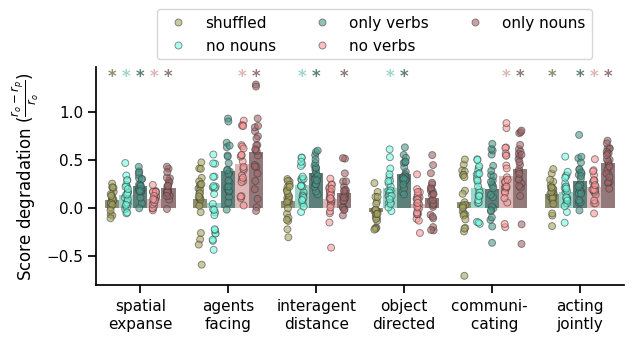

In [11]:
if cut_emotion:
    out_file = '../reports/figures/ResultsSummary/behavior_pertubations_noemotion.pdf'
    figsize=(6.5,3.8)
else:
    out_file = '../reports/figures/ResultsSummary/behavior_pertubations.pdf'
    figsize=(7.5,3.8)
plot_perturbation_summary(ratio_df, 'feature',# reliability_=behavior_reliability,
                          stats=stats, y_label='Score degradation ($\\frac{r_o - r_p}{r_o}$)',
                          y_var='score', figsize=figsize,
                          out_file=out_file)

## Neural

### Functional ROIs

In [124]:
top = '../data/interim/ModelAveraging'
files = glob(f'{top}/LanguageNeuralEncoding_backup_*.pkl.gz')
df = []
for file in tqdm(files):
    cdf = pd.read_pickle(file)
    add_perturbation(file, cdf)
    df.append(cdf)
df = pd.concat(df)

neural_metadata = pd.read_csv('../data/interim/ReorganziefMRI/metadata.csv')
df = df.merge(neural_metadata, on='voxel_id')
df_filtered = df.loc[df.roi_name != 'none'].reset_index()

stats_df = df_filtered.groupby(['perturbation',
                                'roi_name']).agg({'test_score': 'mean', 
                                                  'layer_relative_depth': 'mean',
                                                  'r_null_dist': mean_of_arrays,
                                                  })
stats = []
for perturbation in perturbations:
    for roi in rois:
        null_diff = stats_df.loc['original', roi]['r_null_dist'] - stats_df.loc[perturbation, roi]['r_null_dist'] 
        diff = stats_df.loc['original', roi]['test_score'] - stats_df.loc[perturbation, roi]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='greater')
        stats.append({'perturbation': perturbation, 'roi_name': roi, 'p': p})
stats = pd.DataFrame(stats)
stats['perturbation'] = pd.Categorical(stats['perturbation'], categories=perturbations, ordered=True)
stats['roi_name'] = pd.Categorical(stats['roi_name'], categories=rois, ordered=True)
stats = stats.sort_values(by=['perturbation', 'roi_name']).reset_index(drop=True)

100%|██████████| 6/6 [00:36<00:00,  6.15s/it]


In [125]:
stats

,perturbation,roi_name,p
0,shuffled,EVC,0.542891
1,shuffled,MT,0.881024
2,shuffled,EBA,0.864227
3,shuffled,LOC,0.088182
4,shuffled,pSTS,0.797441
5,shuffled,aSTS,0.698860
6,shuffled,FFA,0.511298
7,shuffled,PPA,0.623275
8,no nouns,EVC,0.169166
9,no nouns,MT,0.182763


In [126]:
df = []
for file in glob('../data/interim/ModelSummary/*LanguageNeuralEncoding_backup**roi_name*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)

models = df.model_uid.unique()
ratio_df = []
for roi, rdf in tqdm(df.groupby('roi_name')):
    orig = rdf.loc[rdf.perturbation == 'original']
    orig.set_index('model_uid', inplace=True)
    for perturb, pdf in rdf.loc[rdf.perturbation != 'original'].groupby('perturbation'):
        pdf.set_index('model_uid', inplace=True)
        for model_uid in models:
            score_ratio = (orig.loc[model_uid, 'score'] - pdf.loc[model_uid, 'score'])/orig.loc[model_uid, 'score']
            ratio_df.append({'model_uid': model_uid,
                             'perturbation': perturb,
                             'roi_name': roi,
                             'score': score_ratio})
ratio_df = pd.DataFrame(ratio_df)
ratio_df['perturbation'] = pd.Categorical(ratio_df['perturbation'], categories=perturbations, ordered=True)
ratio_df.head()

100%|██████████| 8/8 [00:00<00:00, 236.96it/s]


,model_uid,perturbation,roi_name,score
0,FacebookAI_roberta-base,no nouns,EBA,0.075302
1,FacebookAI_roberta-large-mnli,no nouns,EBA,0.012204
2,FacebookAI_xlm-roberta-base,no nouns,EBA,0.272486
3,FacebookAI_xlm-roberta-large,no nouns,EBA,0.395754
4,gpt2,no nouns,EBA,0.146337


#### plotting

In [143]:
def plot_neural_perturbation_summary(df_, category, roi_grouping, 
                                      reliability_=None, out_file=None, stats=None,
                                      y_var='test_score', y_label='Score ($r$)', 
                                      palette_name=None, stats_ypos=None):
    
    custom_colors = ['#A7A659', '#72FFE3', '#449A8B', '#FF9798', '#A66568']
    sns.set_palette(sns.color_palette(custom_colors))
    _, axes = plt.subplots(1, 2, figsize=(8, 3.5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    regions = ['Lateral ROIs', 'Ventral ROIs']
    
    y = df_[y_var].max() + 0.03
    
    for i_ax, (ax, (stream_name, cur_scores)) in enumerate(zip(axes, df_.groupby('roi_stream'))):    
        legend = True if i_ax == 1 else False
        cur_scores.reset_index(drop=True, inplace=True)
        cur_scores[category] = pd.Categorical(cur_scores[category], ordered=True,
                                              categories=roi_grouping[i_ax])
        sns.stripplot(x=category, y=y_var, hue='perturbation', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.7,
                  zorder=2, legend=legend, alpha=.6)
        bars = sns.barplot(x=category, y=y_var, hue='perturbation', data=cur_scores,
                            ax=ax, dodge=True, errorbar=None, saturation=.4,
                            legend=False, zorder=0)

        if stats is not None:
            cur_stats = stats.loc[stats.roi_name.isin(roi_grouping[i_ax])].reset_index(drop=True)
            counter = -1
            for i_container, container in enumerate(bars.containers):
                for i_bar, bar in enumerate(container.patches):
                    counter += 1
                    p = cur_stats.iloc[counter]['p']
                    if p < 0.05:

                        # bar.set_edgecolor(bar.get_facecolor())
                        # bar.set_linewidth(0.5)
                        # bar.set_facecolor('white')
                        x = bar.get_x() + (bar.get_width() / 2)
                        color = list(bar.get_facecolor())
                        color[-1] = 1.
                        ax.text(y=y, x=x, s='*', #p_to_astericks(p),
                                horizontalalignment='center', 
                                color=tuple(color),
                                fontsize=12, weight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ticks = ax.get_xticks()
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticks(ticks)
        ax.set_xlabel(stream_name)
        ax.set_ylabel(y_label)
    plt.tight_layout()
    ax.legend(loc='center right', bbox_to_anchor=(.2, 1.15),
          ncol=3, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file, bbox_inches='tight')

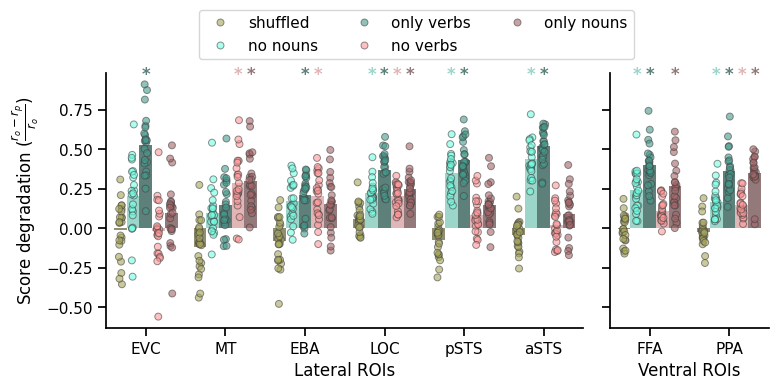

In [144]:
ratio_df['roi_stream'] = 'Lateral ROIs' 
ratio_df.loc[ratio_df.roi_name.isin(['FFA', 'PPA']), 'roi_stream'] = 'Ventral ROIs'
roi_grouping = [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']]
plot_neural_perturbation_summary(ratio_df, 'roi_name',
                                 roi_grouping, stats=stats,
                          y_var='score', y_label='Score degradation ($\\frac{r_o - r_p}{r_o}$)',
                          out_file=f'{figure_path}/brain_pertubations.pdf')

### Anatomical ROIs

In [ ]:
top = '../data/interim/ModelAveraging'
files = glob(f'{top}/LanguageNeuralEncoding_*.pkl.gz')
df = []
for file in tqdm(files):
    cdf = pd.read_pickle(file)
    add_perturbation(file, cdf)
    df.append(cdf)
df = pd.concat(df)

neural_metadata = pd.read_csv('../data/interim/ReorganziefMRI/metadata.csv')
df = df.merge(neural_metadata, on='voxel_id')
df_filtered = df.loc[df.roi_name != 'none'].reset_index()

stats_df = df_filtered.groupby(['perturbation',
                                'stream_name']).agg({'test_score': 'mean', 
                                                  'layer_relative_depth': 'mean',
                                                  'r_null_dist': mean_of_arrays,
                                                  })
stats = []
for perturbation in perturbations:
    for roi in rois:
        null_diff = stats_df.loc['original', roi]['r_null_dist'] - stats_df.loc[perturbation, roi]['r_null_dist'] 
        diff = stats_df.loc['original', roi]['test_score'] - stats_df.loc[perturbation, roi]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='greater')
        stats.append({'perturbation': perturbation, 'stream_name': roi, 'p': p})
stats = pd.DataFrame(stats)
stats['perturbation'] = pd.Categorical(stats['perturbation'], categories=perturbations, ordered=True)
stats['stream_name'] = pd.Categorical(stats['stream_name'], categories=rois, ordered=True)
stats = stats.sort_values(by=['perturbation', 'stream_name']).reset_index(drop=True)

In [17]:
def plot_stream_perturbation_summary(df_, category, roi_grouping, 
                                     tick_labels=None, 
                                      reliability_=None, out_file=None, stats=None,
                                      y_var='test_score', y_label='Score ($r$)', 
                                      palette_name=None, stats_ypos=None):
    if palette_name is None:
        palette = sns.color_palette("Paired", df_.perturbation.nunique())
    else:
        palette = sns.color_palette(palette_name, df_.perturbation.nunique())
    sns.set_context(context='notebook')
    _, axes = plt.subplots(1, 3, figsize=(6.5,3.3), gridspec_kw={'width_ratios': [1, 2, 2]},
                          sharey=True)
    regions = ['', 'Ventral stream', 'Lateral stream']
    for i_ax, (ax, (_, cur_scores)) in enumerate(zip(axes, df_.groupby('roi_stream'))):    
        legend = True if i_ax == 1 else False
        cur_scores.reset_index(drop=True, inplace=True)
        cur_scores[category] = pd.Categorical(cur_scores[category], ordered=True,
                                              categories=roi_grouping[i_ax])
        sns.stripplot(x=category, y=y_var, hue='perturbation', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      zorder=1, palette=palette, legend=legend)
        bars = sns.barplot(x=category, y=y_var, hue='perturbation', data=cur_scores,
                            ax=ax, dodge=True, errorbar=None, saturation=.25,
                            legend=False, zorder=0, palette=palette)

        if stats is not None: 
            # Adding significance lines    
            original_container = bars.containers[0]
            containers = bars.containers[1:]

            counter = -1
            for i_container, container in enumerate(containers):
                for i_bar, bar in enumerate(container.patches):
                    counter += 1
                    if stats.iloc[counter]['p'] < 0.05: 
                        x_min = original_container.patches[i_bar].get_x() + bar.get_width() / 2
                        x_max = bar.get_x() + bar.get_width() / 2
                        yval = stats_ypos[stats.iloc[counter]['perturbation']]
                        plt.hlines(y=yval, xmin=x_min, xmax=x_max,
                                   color=bar.get_facecolor(), linewidth=2)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if tick_labels is not None:
            ax.set_xticks(ax.get_xticks()) 
            ax.set_xticklabels(tick_labels[i_ax])
        ax.set_xlabel(regions[i_ax])
        ax.set_ylabel(y_label)
    plt.tight_layout()
    axes[1].legend(loc='upper right', bbox_to_anchor=(1.85, 1.275),
          ncol=3, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file, bbox_inches='tight')

In [18]:
df = []
for file in glob('../data/interim/ModelSummary/*LanguageNeuralEncoding*stream_name*csv.gz'):
    df.append(add_perturbation(file, pd.read_csv(file)))
df = pd.concat(df)
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [19]:
models = df.model_uid.unique()
ratio_df = []
for stream, fdf in tqdm(df.groupby('stream_name')):
    orig = fdf.loc[fdf.perturbation == 'original']
    orig.set_index('model_uid', inplace=True)
    for perturb, pdf in fdf.loc[fdf.perturbation != 'original'].groupby('perturbation'):
        pdf.set_index('model_uid', inplace=True)
        for model_uid in models:
            try:
                score_ratio = (orig.loc[model_uid, 'score'] - pdf.loc[model_uid, 'score'])/orig.loc[model_uid, 'score']
                ratio_df.append({'model_uid': model_uid,
                                 'perturbation': perturb,
                                 'stream_name': stream,
                                 'score': score_ratio})
            except:
                continue
ratio_df = pd.DataFrame(ratio_df)
ratio_df['perturbation'] = pd.Categorical(ratio_df['perturbation'], categories=perturbations, ordered=True)
ratio_df.head()

100%|██████████| 7/7 [00:00<00:00, 263.41it/s]


,model_uid,perturbation,stream_name,score
0,FacebookAI_roberta-base,no nouns,evc,0.295636
1,FacebookAI_roberta-large-mnli,no nouns,evc,0.020998
2,FacebookAI_xlm-roberta-base,no nouns,evc,-0.165279
3,FacebookAI_xlm-roberta-large,no nouns,evc,-0.275476
4,gpt2,no nouns,evc,0.359190


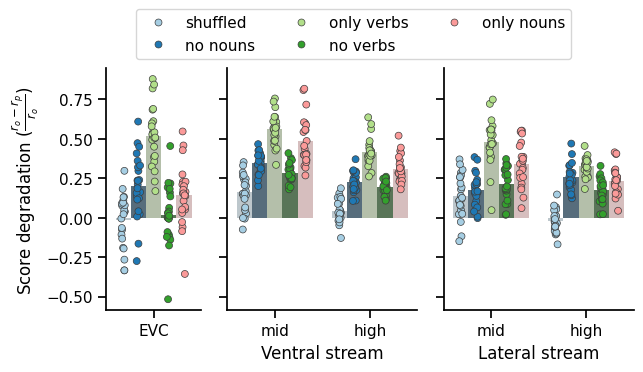

In [20]:
ratio_df['roi_stream'] = 'evc' 
ratio_df.loc[ratio_df.stream_name.isin(['mid_ventral', 'high_ventral']), 'roi_stream'] = 'Ventral stream'
ratio_df.loc[ratio_df.stream_name.isin(['mid_lateral', 'high_lateral']), 'roi_stream'] = 'Lateral stream'
ratio_df['roi_stream'] = pd.Categorical(ratio_df['roi_stream'], categories=['evc', 'Ventral stream', 'Lateral stream'],
                                   ordered=True)
roi_grouping = [['evc'], ['mid_ventral', 'high_ventral'], ['mid_lateral', 'high_lateral']]
tick_labels = [['EVC'], ['mid', 'high'], ['mid', 'high']]
plot_stream_perturbation_summary(ratio_df, 'stream_name', roi_grouping,
                          y_var='score', tick_labels=tick_labels,
                                 y_label='Score degradation ($\\frac{r_o - r_p}{r_o}$)',
                          out_file=f'{figure_path}/stream_pertubations.pdf')

# Image vs Video vs Language

## Behavior

In [21]:
top = '../data/interim/ModelAveraging/'
files = [f'{top}/LanguageBehaviorEncoding_none.pkl.gz']
files += [f'{top}/VisionBehaviorEncoding_grouped_average.pkl.gz']
files += [f'{top}/VideoBehaviorEncoding_None.pkl.gz']

df = []
for file in files:
    cdf = pd.read_pickle(file)
    add_model_class(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df['feature'] = df['feature'].replace(feature_naming(df.feature.unique()))
df = df.loc[df.feature.isin(annotated_features)].reset_index(drop=True)
df.set_index(['model_class', 'feature'], inplace=True)

stats = []
model_classes = ['image', 'video', 'language']
for feature in annotated_features:
    for m1, m2 in combinations(model_classes, 2):
        null_diff = df.loc[m1, feature]['r_null_dist'] - df.loc[m2, feature]['r_null_dist'] 
        diff = df.loc[m1, feature]['test_score'] - df.loc[m2, feature]['test_score']
        p = calculate_p(null_diff, diff, n_perm_=len(null_diff), H0_='two_tailed')
        stats.append({'model1': m1, 'model2': m2, 'feature': feature, 'p': p})
stats = pd.DataFrame(stats)
stats.set_index(['feature', 'model1', 'model2'], inplace=True)

In [22]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageBehaviorEncoding_none.csv.gz']
files += [f'{top}/VisionBehaviorEncoding_grouped_average.csv.gz']
files += [f'{top}/VideoBehaviorEncoding_None.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df.replace(feature_naming(df.feature.unique()), inplace=True)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
if cut_emotion:
    df = df.loc[~df['feature'].isin(['valence', 'arousal'])].reset_index(drop=True)

df['feature'] = pd.Categorical(df['feature'], ordered=True, 
                                   categories=annotated_features)
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [23]:
def plot_combined_behavior_summary(df_, reliability_, hue='model_class',
                                   stats=None, features=None, grouping=None,
                                   out_file=None):
    anchor = (.8, 1.2)
    if hue == 'model_class':
        sns.set_palette(['tab:cyan', 'tab:purple'])
    elif hue == 'model_type':
        sns.set_palette(['tab:cyan', 'tab:purple'])
        anchor = (.7, 1.2)
    elif hue == 'architecture_type':
        sns.set_palette(['tab:orange', 'tab:green'])
    elif hue == 'task_cluster':
        sns.set_palette(['tab:red', 'gold'])
    elif hue == 'modality':
        sns.set_palette(['tab:pink', 'skyblue'])
        
    n = df_[hue].nunique()
    if n == 3:
        dodge = 0.55
        markersize = 13.25
    else:
        dodge = 0.4
        markersize = 16

    sns.set_context(context='notebook')
    _, ax = plt.subplots(figsize=(6.5,3.65))
    sns.stripplot(x='feature', y='score', hue=hue, data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=1, legend=False)
    sns.pointplot(x='feature', y='score', hue=hue, data=df_,
                  dodge=dodge, linestyle="none", errorbar=None,
                  marker="_", markersize=markersize, markeredgewidth=3, zorder=2)
    sns.pointplot(x='feature', y='reliability', data=reliability_,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=30, markeredgewidth=5,
                  color='gray', alpha=.5, zorder=0)
            
    # Plot the mean
    if stats is not None:
        xpos = list(np.linspace(-1*(dodge/2), (dodge/2), n))
        y = df_['score'].max()
        for x, feature in zip(range(len(features)), features):
            jitter = 0.09
            for (x1, x2), (m1, m2) in zip(combinations(xpos, 2), combinations(grouping,2)):
                p = stats.loc[feature, m1, m2]['p']
                if p < 0.05:
                    ax.hlines(y=y+jitter, xmin=x+x1, xmax=x+x2,
                              color='black', linewidth=0.5)
                    ax.vlines(ymin=y+jitter-0.01, ymax=y+jitter+0.001,
                              x=[x+x1, x+x2], color='black', linewidth=0.5)
                    x_center = x + x1 + ((x2-x1)/2)
                    ax.text(y=y+jitter-0.02, x=x_center, s=p_to_astericks(p),
                            horizontalalignment='center', color='black')
                    jitter += 0.09
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xlabel('')
    ax.set_ylabel('Score ($r$)')
    ax.legend(loc='upper right', bbox_to_anchor=anchor,
              ncol=n, fancybox=True)
    
    # Manually insert line breaks in tick labels
    tick_labels = ax.get_xticklabels()
    for label in tick_labels:
        # Insert a line break after the first word
        new_label = label.get_text().replace(' ', '\n', 1)
        if label.get_text() == 'communicating':
            new_label = 'communi- \n cating'
        size = label.get_fontsize()
        label.set_text(new_label)
        label.set_fontsize(size-1)
    ax.set_xticklabels(tick_labels)
    
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file, bbox_inches='tight')

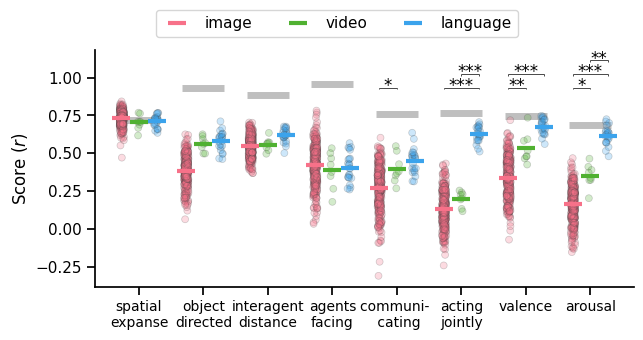

In [24]:
if cut_emotion:
    out_file = f'{figure_path}/behavior_main_noemotion.pdf'
else:
    out_file = f'{figure_path}/behavior_main.pdf'
plot_combined_behavior_summary(df, behavior_reliability,
                               out_file=out_file,
                              stats=stats, features=annotated_features,
                               grouping=model_classes)

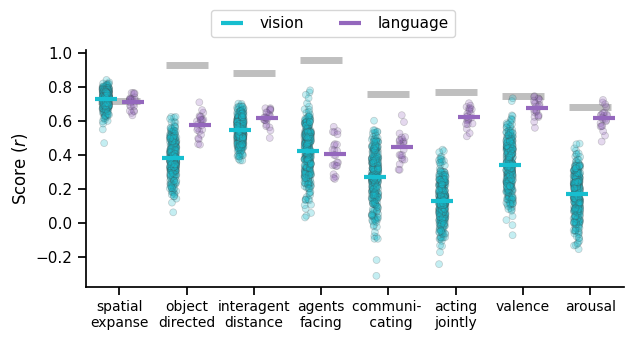

In [25]:
if cut_emotion:
    out_file = f'{figure_path}/behavior_vision-language_noemotion.pdf'
else:
    out_file = f'{figure_path}/behavior_vision-language.pdf'
plot_combined_behavior_summary(df, behavior_reliability, hue='model_type',
                               out_file=out_file)

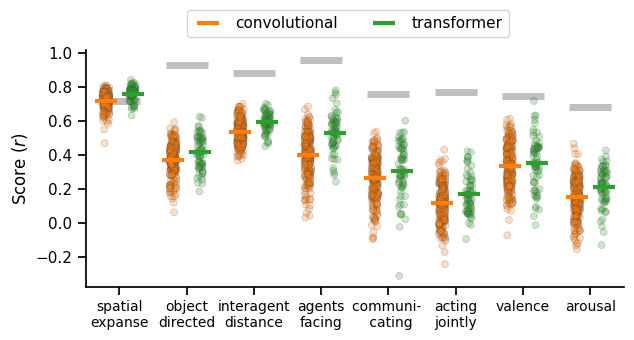

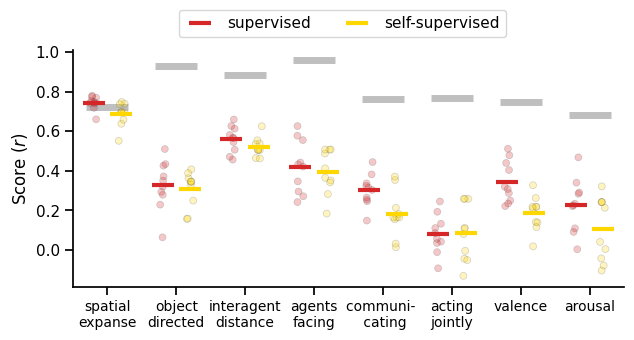

In [26]:
if not cut_emotion:
    image_df = df.loc[df.model_class == 'image'].reset_index(drop=True).merge(model_info, on='model_uid')

    conv_meta_max = image_df[image_df['architecture_type'].isin(['Convolutional', 'Transformer'])]
    mapping = {i: i.lower() for i in ['Convolutional', 'Transformer']}
    conv_meta_max.replace(mapping, inplace=True)
    conv_meta_max['architecture_type'] = pd.Categorical(conv_meta_max['architecture_type'], 
                                                        categories=mapping.values(), ordered=True)
    plot_combined_behavior_summary(conv_meta_max, behavior_reliability,
                                   hue='architecture_type',
                                   out_file=f'{figure_path}/behavior_architecutre.pdf')

    categories = ['Supervised', 'Self-Supervised']

    resnet_info = model_info[(model_info['model_source'].isin(['torchvision', 'vissl', 'dino', 'timm'])) & (model_info['architecture'].str.contains('resnet50'))]
    resnet_df = image_df[image_df['model_uid'].isin(resnet_info.model_uid)]
    sup_meta_max = resnet_df[resnet_df['task_cluster'].isin(categories)]
    mapping = {i: i.lower() for i in categories}
    sup_meta_max.replace(mapping, inplace=True)
    sup_meta_max['task_cluster'] = pd.Categorical(sup_meta_max['task_cluster'], 
                                                        categories=mapping.values(), ordered=True)

    plot_combined_behavior_summary(sup_meta_max, behavior_reliability,
                                   hue='task_cluster',
                                   out_file=f'{figure_path}/behavior_objective-function.pdf')

## Neural

### Functional ROIs

In [27]:
top = '../data/interim/ModelAveraging'
files = [f'{top}/LanguageNeuralEncoding_none.pkl.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average.pkl.gz']
files += [f'{top}/VideoNeuralEncoding_None.pkl.gz']
df = []
for file in tqdm(files):
    cdf = pd.read_pickle(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)

neural_metadata = pd.read_csv('../data/interim/ReorganziefMRI/metadata.csv')
df = df.merge(neural_metadata, on='voxel_id')
df_filtered = df.loc[df.roi_name != 'none'].reset_index()

stats_df = df_filtered.groupby(['roi_name',
                                'model_class']).agg({'test_score': 'mean', 
                                                     'layer_relative_depth': 'mean',
                                                     'reliability': 'mean',
                                                     'r_null_dist': mean_of_arrays,
                                                    }).reset_index()

stats = []
model_classes = ['image', 'video', 'language']
for roi, roi_df in stats_df.groupby('roi_name'):
    roi_df.set_index('model_class', inplace=True)
    for model1, model2 in combinations(model_classes, 2):
        null_diff = roi_df.loc[model1, 'r_null_dist'] - roi_df.loc[model2, 'r_null_dist']
        r_diff = roi_df.loc[model1, 'test_score'] - roi_df.loc[model2, 'test_score']
        p = calculate_p(null_diff, r_diff,
                        n_perm_=len(null_diff), H0_='two_tailed')
        stats.append({'roi_name': roi,
                      'model1': model1, 'model2': model2, 'p': p})
stats = pd.DataFrame(stats)

100%|██████████| 3/3 [00:18<00:00,  6.21s/it]


In [28]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageNeuralEncoding_none_roi_name.csv.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average_roi_name.csv.gz']
files += [f'{top}/VideoNeuralEncoding_None_roi_name.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [29]:
def plot_combined_neural_fROIs(df_, hue='model_class',
                               stats=None, grouping=None,
                               out_file=None):
    anchor = (1, 1.2)
    if hue == 'model_class':
        sns.set_palette(['tab:cyan', 'tab:purple'])
        anchor = (1, 1.2)
    elif hue == 'model_type':
        sns.set_palette(['tab:cyan', 'tab:purple'])
    elif hue == 'architecture_type':
        sns.set_palette(['tab:orange', 'tab:green'])
    elif hue == 'task_cluster':
        sns.set_palette(['tab:red', 'gold'])
    elif hue == 'modality':
        sns.set_palette(['tab:pink', 'skyblue'])
    regions = ['Lateral ROIs', 'Ventral ROIs']
    
    n = df_[hue].nunique()
    if n == 3:
        dodge = 0.55
        markersize = 13.5
    else:
        dodge = 0.4
        markersize = 18

    _, axes = plt.subplots(1, 2, figsize=(6.5, 3.5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                               ['FFA', 'PPA']])):
        legend = True if i_ax == 0 else False

        cur_scores = df_[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        cur_scores.sort_values(['roi_name', 'model_class'], inplace=True)
        sns.stripplot(x='roi_name', y='score', hue=hue, data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=1, legend=False)
        sns.pointplot(x='roi_name', y='score', hue=hue,
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=dodge, linestyle="none", errorbar=None,
                      marker="_", markersize=markersize,
                      markeredgewidth=3, zorder=2)
        
        # Plot the mean
        if stats is not None:
            cur_stats = stats[stats.roi_name.isin(cur_rois)].set_index(['roi_name', 'model1', 'model2'])
            xpos = list(np.linspace(-1*(dodge/2), (dodge/2), n))
            y = cur_scores['score'].max()
            for x, roi in zip(range(len(cur_rois)), cur_rois):
                jitter = 0.05
                for (x1, x2), (m1, m2) in zip(combinations(xpos, 2), combinations(grouping,2)):
                    p = cur_stats.loc[roi, m1, m2]['p']
                    if p < 0.05:
                        ax.hlines(y=y+jitter, xmin=x+x1, xmax=x+x2,
                                  color='black', linewidth=0.5)
                        ax.vlines(ymin=y+jitter-0.01, ymax=y+jitter+0.001,
                                  x=[x+x1, x+x2], color='black', linewidth=0.5)
                        x_center = x + x1 + ((x2-x1)/2)
                        ax.text(y=y+jitter, x=x_center, s=p_to_astericks(p),
                                horizontalalignment='center', color='black')
                        jitter += 0.05
                    
        # Plot the reliability
        sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=45, markeredgewidth=5,
              alpha=.5, zorder=0, ax=ax)
                    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(regions[i_ax])
        if i_ax == 0: 
            ax.set_ylabel('Score ($r$)')
            ax.legend(loc='upper right', bbox_to_anchor=anchor,
                      ncol=n, fancybox=True)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)

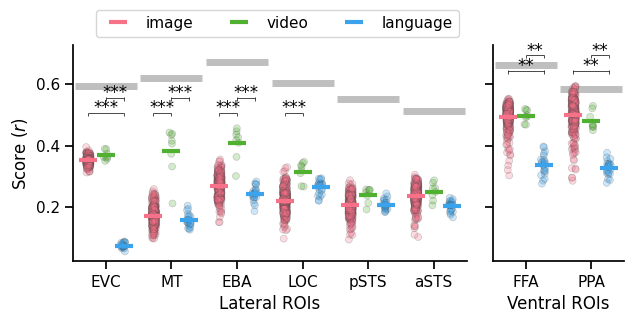

In [30]:
plot_combined_neural_fROIs(df, hue='model_class', stats=stats, grouping=model_classes, 
                           out_file=f'{figure_path}/brain_main.pdf')

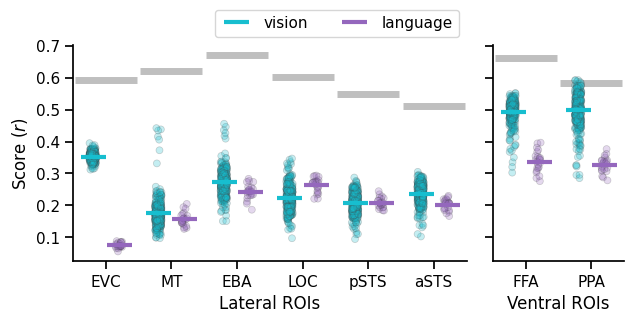

In [31]:
plot_combined_neural_fROIs(df, hue='model_type',
                     out_file=f'{figure_path}/neural_vision-language.pdf')

In [32]:
image_df = df.loc[df.model_class == 'image'].reset_index(drop=True).merge(model_info, on='model_uid')

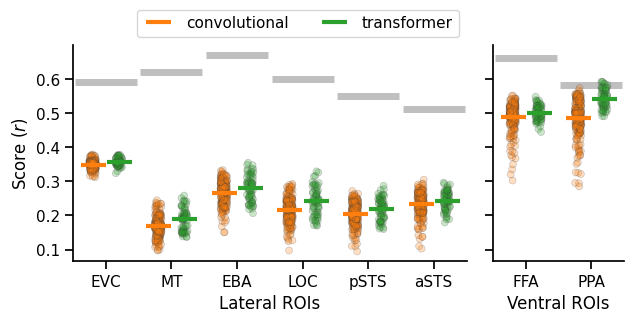

In [33]:
categories = ['Convolutional', 'Transformer']
hue = 'architecture_type' 

conv_meta_max = image_df[image_df[hue].isin(categories)]
mapping = {i: i.lower() for i in categories}
conv_meta_max.replace(mapping, inplace=True)
conv_meta_max[hue] = pd.Categorical(conv_meta_max[hue],
                                    categories=mapping.values(), ordered=True)
plot_combined_neural_fROIs(conv_meta_max, hue=hue,
                     out_file=f'{figure_path}/brain_architecture.pdf')

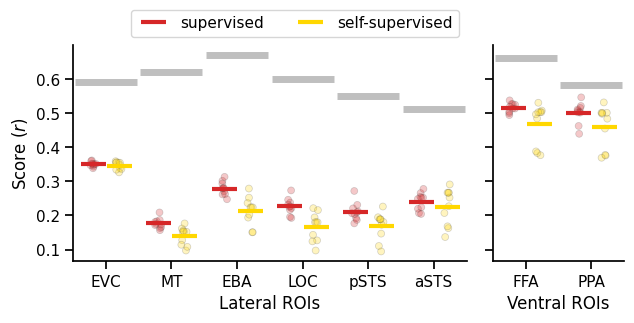

In [34]:
categories = ['Supervised', 'Self-Supervised']
hue = 'task_cluster' 

resnet_info = model_info[(model_info['model_source'].isin(['torchvision', 'vissl', 'dino', 'timm'])) & (model_info['architecture'].str.contains('resnet50'))]
resnet_df = image_df[image_df['model_uid'].isin(resnet_info.model_uid)]
sup_meta_max = resnet_df[resnet_df[hue].isin(categories)]
mapping = {i: i.lower() for i in categories}
sup_meta_max.replace(mapping, inplace=True)
sup_meta_max[hue] = pd.Categorical(sup_meta_max[hue],
                                   categories=mapping.values(), ordered=True)

plot_combined_neural_fROIs(sup_meta_max, hue=hue,
                     out_file=f'{figure_path}/brain_objective-function.pdf')

### Anatomical ROIs

In [35]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageNeuralEncoding_none_stream_name.csv.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average_stream_name.csv.gz']
files += [f'{top}/VideoNeuralEncoding_None_stream_name.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [36]:
def plot_combined_neural_aROIs(df_, hue='model_class', out_file=None):
    anchor = (1.2, 1.275)
    if hue == 'model_class':
        sns.set_palette(['tab:cyan', 'tab:purple'])
        anchor = (1.55, 1.275)
    elif hue == 'model_type':
        sns.set_palette(['tab:cyan', 'tab:purple'])
    elif hue == 'architecture_type':
        sns.set_palette(['tab:orange', 'tab:green'])
    elif hue == 'task_cluster':
        sns.set_palette(['tab:red', 'gold'])
    elif hue == 'modality':
        sns.set_palette(['tab:pink', 'skyblue'])
    regions = ['', 'Ventral stream', 'Lateral stream',]
    
    if df_[hue].nunique() == 3:
        dodge = 0.55
        markersize = 14
    else:
        dodge = 0.4
        markersize = 18
    
    sns.set_context(context='notebook')
    _, axes = plt.subplots(1, 3, figsize=(6.5,3.25),
                           gridspec_kw={'width_ratios': [1, 2, 2]},
                          sharey=True)
    for i_ax, (ax, (cur_rois, ticks)) in enumerate(zip(axes, zip([['evc'],
                                                                  ['mid_ventral', 'high_ventral'],
                                                                  ['mid_lateral', 'high_lateral'],
                                                                 ],
                                                                 [['EVC'], ['mid', 'high'],
                                                                  ['mid', 'high']]))):
        legend = True if i_ax == 1 else False
        cur_scores = df_[df_.stream_name.isin(cur_rois)]
        cur_scores['stream_name'] = pd.Categorical(cur_scores['stream_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='stream_name', y='score', hue=hue, data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=1, legend=False)
        sns.pointplot(x='stream_name', y='score', hue=hue,
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=dodge, linestyle="none", errorbar=None,
                      marker="_", markersize=markersize,
                      markeredgewidth=3, zorder=2)
        sns.pointplot(x='stream_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=45, markeredgewidth=5,
              alpha=.5, zorder=0, ax=ax)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(regions[i_ax])
        ax.set_ylabel('Score ($r$)')
        ax.set_xticks(cur_rois) 
        ax.set_xticklabels(ticks)
    plt.tight_layout()
    axes[1].legend(loc='upper right', bbox_to_anchor=anchor,
          ncol=df_[hue].nunique(), fancybox=True)
    if out_file is not None:
        plt.savefig(out_file, bbox_inches='tight')

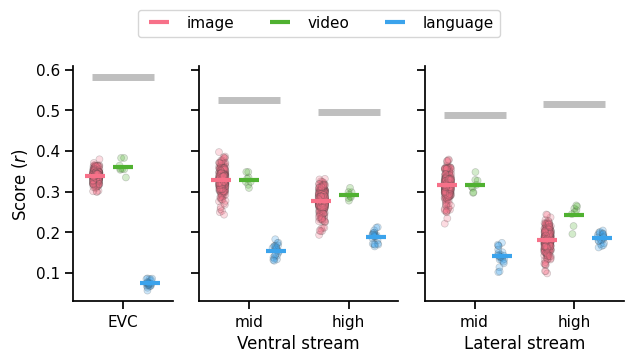

In [37]:
plot_combined_neural_aROIs(df, hue='model_class',
                           out_file=f'{figure_path}/stream_main.pdf')

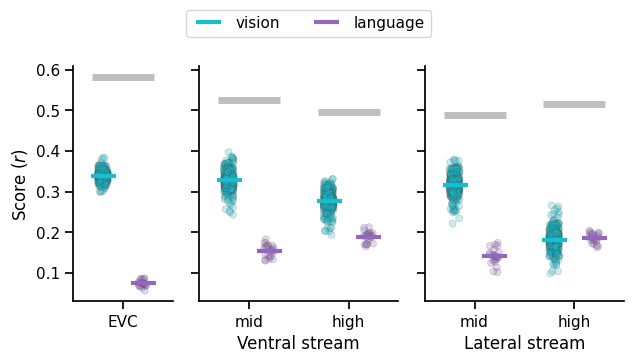

In [38]:
plot_combined_neural_aROIs(df, hue='model_type',
                           out_file=f'{figure_path}/stream_vison-language.pdf')

# Hierarchy

In [39]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/VisionNeuralEncoding_grouped_average_roi_name.csv.gz']
files += [f'{top}/VideoNeuralEncoding_None_roi_name.csv.gz']

df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)
df.head()

,model_uid,layer_index,layer_relative_depth,roi_name,reliability,set,score,normalized_score
0,bit_expert_abstraction,141.349081,0.812351,EBA,0.671132,train,0.396543,0.590857
1,bit_expert_animal,139.094631,0.799394,EBA,0.671132,train,0.393275,0.585988
2,bit_expert_arthropod,146.220751,0.840349,EBA,0.671132,train,0.387865,0.577926
3,bit_expert_bird,133.859175,0.769306,EBA,0.671132,train,0.387803,0.577834
4,bit_expert_flower,136.521314,0.784605,EBA,0.671132,train,0.396700,0.591091


In [40]:
def plot_neural_hierarchy(df_, out_file=None):
    _, ax = plt.subplots(figsize=(6.5,4))
    sns.set_palette('mako_r')
    sns.set_context('talk')
    color = ['gray', 'gray', 'gray']
    unique_model_uids = df_['model_uid'].unique()
    color_palette = {uid: 'gray' for uid in unique_model_uids}
    df_test = df_[df_.set == 'test']
    cur_rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS']
    cur_scores = df_test[df_test.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    cur_scores_avg = cur_scores.groupby('roi_name', observed=True).mean(numeric_only=True)
    sns.pointplot(x='roi_name', y='layer_relative_depth', data=cur_scores_avg,
                 marker='.', markersize=10, zorder=1, color='purple',
                 ax=ax, legend=False)
    sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid',
                 data=cur_scores, ax=ax,
                 linewidth=.5, alpha=0.25, zorder=0,
                 legend=False, palette=color_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0,1])
    ax.set_xlabel('Lateral ROIs')
    ax.set_ylabel('Relative layer depth')
    if out_file is not None:
        plt.savefig(out_file)

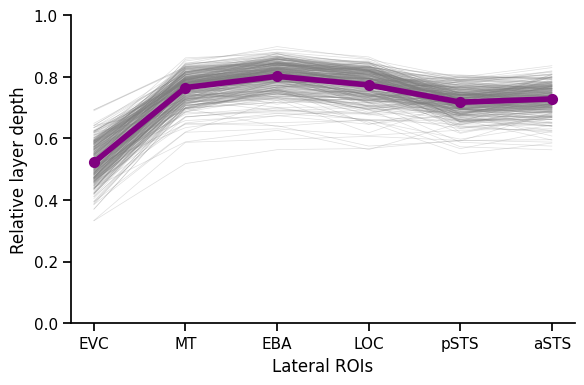

In [41]:
plot_neural_hierarchy(df, out_file=f'{figure_path}/brain_hiearchy.pdf')

# Whole Brain summaries

## Vision - Language

In [42]:
top = '../data/interim/ModelAveraging'
files = [f'{top}/LanguageNeuralEncoding_none.pkl.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average.pkl.gz']
files += [f'{top}/VideoNeuralEncoding_None.pkl.gz']
df = []
for file in tqdm(files):
    cdf = pd.read_pickle(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)

100%|██████████| 3/3 [00:18<00:00,  6.12s/it]


In [43]:
df_wholebrain = df.drop(columns=['r_null_dist'])
df_vision = df_wholebrain.loc[df_wholebrain.model_type == 'vision']
n_models = np.array(df_vision.n_models.unique()).sum()
print(n_models)
vision_avg = []
for voxel_id, voxel_df in tqdm(df_vision.groupby('voxel_id')):
    voxel_df.set_index('model_class', inplace=True)
    voxel_result = {'voxel_id': voxel_id, 'model_type': 'vision'}
    
    for col in ['test_score', 'layer_relative_depth']:
        val = 0
        for model_class in ['image', 'video']: 
            val += voxel_df.loc[model_class, col] * (voxel_df.loc[model_class,
                                                                  'n_models']/n_models)
        voxel_result[col] = val
    vision_avg.append(voxel_result)
vision_avg = pd.DataFrame(vision_avg)
vision_avg.set_index('voxel_id', inplace=True)

cols = ['voxel_id', 'model_type', 'test_score', 'layer_relative_depth']
lang_avg = df_wholebrain.loc[df_wholebrain.model_type == 'vision', cols].set_index('voxel_id')
whole_brain_diff = vision_avg['test_score'] - lang_avg['test_score']
whole_brain_diff = pd.DataFrame(whole_brain_diff).merge(neural_metadata, on='voxel_id')
whole_brain_diff.to_csv('../data/interim/ResultsSummary/vision-language_whole-brain.csv.gz', index=False)

vision_avg.to_csv('../data/interim/ResultsSummary/vision_whole-brain.csv.gz', index=False)

350


100%|██████████| 177753/177753 [00:48<00:00, 3674.13it/s]


# Tables

## Behavior

In [44]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageBehaviorEncoding_none.csv.gz']
files += [f'{top}/VisionBehaviorEncoding_grouped_average.csv.gz']
files += [f'{top}/VideoBehaviorEncoding_None.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    add_model_type(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df.replace(feature_naming(df.feature.unique()), inplace=True)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['model_type'] = pd.Categorical(df['model_type'], ordered=True, 
                                   categories=['vision', 'language'])
df['feature'] = pd.Categorical(df['feature'], ordered=True, 
                                   categories=annotated_features)
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [45]:
model_avg_score = df.groupby('model_uid').mean(numeric_only=True)
best_model = model_avg_score.nlargest(1, 'score').index.tolist()[0]
print(f'The best behavioral model on average is {best_model}')
best_models = model_avg_score.nlargest(10, 'score').index.tolist()
best_model_scores = df.loc[df.model_uid.isin(best_models)].reset_index(drop=True)
pivot_df = best_model_scores.pivot(index=['model_uid', 'model_class'], columns='feature', values='score').reset_index()
pivot_df['model_uid'] = pd.Categorical(pivot_df['model_uid'],
                                       categories=best_models,
                                       ordered=True)
pivot_df.sort_values(by='model_uid', inplace=True)
pivot_df.set_index(['model_uid', 'model_class'], inplace=True)

The best behavioral model on average is sentence-transformers_paraphrase-MiniLM-L6-v2


In [46]:
def highlight_max(row, best_model_score_per_feature):
    indices = [f"{index}" for index in row.name]  # row.name will contain the tuple from the MultiIndex
    out = [' & '.join(indices)]  # Start with the indices, which are the names of the row
        
    # Iterating over items in the row
    for key, value in row.items():
        top_score = best_model_score_per_feature.loc[key, 'score']
        if np.isclose(value, top_score, atol=1e-6):
            out.append(f'\\textbf{{{value:.3f}}}')
        else:
            out.append(f'{value:.3f}')
    return ' & '.join(out) + ' \\\\'

best_model_score_per_feature = df.groupby('feature', observed=True)['score'].max()
best_model_score_per_feature = pd.DataFrame(best_model_score_per_feature)

# Preprocessing and renaming
pivot_df.reset_index(inplace=True)
rename_model = {model: model.replace('sentence-transformers_', '') for model in pivot_df['model_uid'].unique()}
pivot_df['model_uid'] = pivot_df['model_uid'].replace(rename_model)
pivot_df.set_index(['model_uid', 'model_class'], inplace=True)  # Set 'model_uid' as the index for use in the function

# Applying highlight function
formatted_df = pivot_df.apply(highlight_max, axis=1, args=(best_model_score_per_feature,))

# Convert DataFrame to LaTeX
latex_str = '\\begin{tabular}{l' + 'c' * len(annotated_features) + '}\\toprule\n'
latex_str += 'Model name & Model class & ' + ' & '.join(annotated_features) + ' \\\\\\midrule\n'
latex_str += '\n'.join(formatted_df) + '\n\\bottomrule\n\\end{tabular}'
latex_str = latex_str.replace('_', '\\_')

print(latex_str)

\begin{tabular}{lcccccccc}\toprule
Model name & Model class & spatial expanse & object directed & interagent distance & agents facing & communicating & acting jointly & valence & arousal \\\midrule
paraphrase-MiniLM-L6-v2 & language & 0.764 & 0.576 & 0.664 & 0.534 & \textbf{0.635} & 0.583 & 0.692 & 0.684 \\
all-mpnet-base-v2 & language & 0.688 & 0.665 & 0.676 & 0.537 & 0.384 & 0.678 & 0.743 & \textbf{0.725} \\
paraphrase-multilingual-MiniLM-L12-v2 & language & 0.725 & 0.609 & 0.621 & 0.523 & 0.595 & 0.625 & 0.684 & 0.647 \\
all-mpnet-base-v1 & language & 0.766 & \textbf{0.711} & 0.615 & 0.424 & 0.313 & 0.643 & \textbf{0.747} & 0.709 \\
FacebookAI\_roberta-large-mnli & language & 0.725 & 0.605 & 0.608 & 0.567 & 0.468 & 0.683 & 0.664 & 0.605 \\
mixedbread-ai\_mxbai-embed-2d-large-v1 & language & 0.766 & 0.520 & 0.670 & 0.541 & 0.431 & \textbf{0.706} & 0.686 & 0.588 \\
paraphrase-multilingual-mpnet-base-v2 & language & 0.735 & 0.610 & 0.652 & 0.462 & 0.504 & 0.660 & 0.705 & 0.572 \\
all-d

## Brain

In [112]:
top = '../data/interim/ModelTopPerforming'
files = [f'{top}/LanguageNeuralEncoding_none_model-avg.csv']
files += [f'{top}/VisionNeuralEncoding_grouped_average_model-avg.csv']
files += [f'{top}/VideoNeuralEncoding_None_model-avg.csv']
best_df = []
for file in files:
    try:
        best_df.append(pd.read_csv(file))
    except:
        print(f'could not load {file}')
best_df = pd.concat(best_df).reset_index(drop=True)
best_idx = best_df.nlargest(10, 'avg_score').index.tolist()
best_models = best_df.iloc[best_idx]['model_uid'].to_list()
print(best_models)

['x3d_s', 'timm_beitv2_base_patch16_224', 'timm_beitv2_large_patch16_224', 'x3d_m', 'timm_beit_large_patch16_224', 'timm_beit_large_patch16_384', 'clip_vitl14', 'timm_deit3_huge_patch14_224_in21ft1k', 'timm_deit3_large_patch16_384_in21ft1k', 'timm_beit_base_patch16_224']


In [113]:
top = '../data/interim/ModelSummary/'
files = [f'{top}/LanguageNeuralEncoding_none_roi_name.csv.gz']
files += [f'{top}/VisionNeuralEncoding_grouped_average_roi_name.csv.gz']
files += [f'{top}/VideoNeuralEncoding_None_roi_name.csv.gz']
df = []
for file in files:
    cdf = pd.read_csv(file)
    add_model_class(file, cdf)
    df.append(cdf)
df = pd.concat(df)
df['model_class'] = pd.Categorical(df['model_class'], ordered=True, 
                                   categories=['image', 'video', 'language'])
df['roi_name'] = pd.Categorical(df['roi_name'], ordered=True, 
                                   categories=rois)
df = df.loc[df.set == 'test'].reset_index(drop=True)

In [114]:
df = df.loc[df.model_uid.isin(best_models)].reset_index(drop=True)
pivot_df = df.pivot(index=['model_uid', 'model_class'], columns='roi_name', values='score').reset_index()
pivot_df['model_uid'] = pd.Categorical(pivot_df['model_uid'],
                                       categories=best_models,
                                       ordered=True)
pivot_df.sort_values(by='model_uid', inplace=True)
pivot_df.set_index(['model_uid', 'model_class'], inplace=True)

In [115]:
def highlight_max(row, best_model_score_per_roi):
    indices = [f"{index}" for index in row.name]  # row.name will contain the tuple from the MultiIndex
    out = [' & '.join(indices)]  # Start with the indices, which are the names of the row
        
    # Iterating over items in the row
    for key, value in row.items():
        top_score = best_model_score_per_roi.loc[key, 'score']
        if np.isclose(value, top_score, atol=1e-6):
            out.append(f'\\textbf{{{value:.3f}}}')
        else:
            out.append(f'{value:.3f}')
    return ' & '.join(out) + ' \\\\'

best_model_score_per_roi = df.groupby('roi_name', observed=True)['score'].max()
best_model_score_per_roi = pd.DataFrame(best_model_score_per_roi)

# Preprocessing and renaming
pivot_df.reset_index(inplace=True)
rename_model = {model: model.replace('sentence-transformers_', '') for model in pivot_df['model_uid'].unique()}
pivot_df['model_uid'] = pivot_df['model_uid'].replace(rename_model)
pivot_df.set_index(['model_uid', 'model_class'], inplace=True)  # Set 'model_uid' as the index for use in the function

# Applying highlight function
formatted_df = pivot_df.apply(highlight_max, axis=1, args=(best_model_score_per_roi,))

# Convert DataFrame to LaTeX
latex_str = '\\begin{tabular}{l' + 'c' * len(rois) + '}\\toprule\n'
latex_str += 'Model name & Model class & ' + ' & '.join(rois) + ' \\\\\\midrule\n'
latex_str += '\n'.join(formatted_df) + '\n\\bottomrule\n\\end{tabular}'
latex_str = latex_str.replace('_', '\\_')

print(latex_str)

\begin{tabular}{lcccccccc}\toprule
Model name & Model class & EVC & MT & EBA & LOC & pSTS & aSTS & FFA & PPA \\\midrule
x3d\_s & video & \textbf{0.389} & \textbf{0.442} & 0.427 & \textbf{0.347} & 0.256 & 0.261 & 0.519 & 0.521 \\
timm\_beitv2\_base\_patch16\_224 & image & 0.369 & 0.245 & 0.349 & 0.326 & 0.275 & 0.293 & 0.536 & 0.588 \\
timm\_beitv2\_large\_patch16\_224 & image & 0.376 & 0.259 & 0.355 & 0.330 & \textbf{0.287} & 0.291 & 0.524 & 0.593 \\
x3d\_m & video & 0.388 & 0.435 & \textbf{0.456} & 0.343 & 0.247 & 0.287 & 0.516 & 0.493 \\
timm\_beit\_large\_patch16\_224 & image & 0.373 & 0.241 & 0.335 & 0.314 & 0.277 & \textbf{0.297} & 0.520 & 0.592 \\
timm\_beit\_large\_patch16\_384 & image & 0.368 & 0.251 & 0.336 & 0.317 & 0.253 & 0.266 & 0.501 & \textbf{0.593} \\
clip\_vitl14 & image & 0.376 & 0.223 & 0.325 & 0.289 & 0.245 & 0.278 & 0.526 & 0.574 \\
timm\_deit3\_huge\_patch14\_224\_in21ft1k & image & 0.375 & 0.233 & 0.320 & 0.291 & 0.264 & 0.287 & \textbf{0.538} & 0.587 \\
timm\_de